# CW2 - DDBA

In [1615]:
from datetime import datetime
import os
import pandas as pd
from datetime import timedelta
import numpy as np
import math

# Initial variables

Parameters:
* Allocate an amount of b Bitcoin and g GBP to every agent at the start; all agents should start with the same amount of GBP and Bitcoin . 
* To represent real-life scenarios, every 90 days additional Bitcoin amounting to 10% of the Bitcoin currently in circulation enter the market and those are assigned to agents, giving them an amount of Bitcoin proportional to those already owned following the Gibrat principle of preferential attachment (rich get richer).

In [1616]:
# Market conditions

INITIAL_PRICE = 5444	
INITIAL_BTC = 18
INITIAL_GBP = INITIAL_PRICE*INITIAL_BTC 

INITIAL_DATE = datetime.strptime("2020-01-01", "%Y-%m-%d") 
FINAL_DATE = datetime.strptime("2024-11-01", "%Y-%m-%d")
t = (FINAL_DATE - INITIAL_DATE).days # number of time steps

N_DAYS_NEW_BITCOIN = 90 #90 # every 90 days increase the amount of bitcoin by 10%
PORCENTAGE_NEW_BITCOIN = 0.1 # every 90 days increase the amount of bitcoin by 10%

# Constraints
MIN_PRICE = 1 # minimum price of bitcoin constrain

# Variables for the trading strategy - chartist
N_MOMENTUM = 2 # number of days to calculate the momentum

# Agents
n = 1000 # number of agents

# Porcentages of agents of each type
p_R = 0.3 # porcentage of random agents
p_C1 = 0.15 # porcentage of chartist 1
p_C2 = 0.15 # porcentage of chartist 2
p_C3 = 0.15 # porcentage of chartist 3
p_C4 = 0.15 # porcentage of chartist 4
p_CT = 1 - p_R - p_C1 - p_C2 - p_C3 - p_C4 


In [1617]:
t

1766

# Agents

Conditions: 
* Agents can only open a new position if they have closed their previous position (except for the initial position which can be initiated before previous close). To close a position in the model an agent needs to sell all the Bitcoin they obtained when they opened the position.

In [1618]:
import uuid
import random

class Agent: 
    n_id = 0
    random.seed(1)
    
    def __init__(self, btc, gbp, type):
        Agent.n_id = Agent.n_id + 1
        self.id = Agent.n_id 
        self.btc = btc
        self.gbp = gbp
        self.type = type # R:Random, C1:Chartist (80/20), C2:Chartist(20/80), C3:Chartist(50/50), C4:Chartist(100% -RSI)
        self.position = False #(True = Open position, compró, False = Closed position, vendió)

        # History of the agent
        self.h_decisions = [] # history of decisions    
        self.h_positions = [] # history of positions
        self.h_wealth = [] # history of wealth
        self.h_gbp = [] # history of gbp
        self.h_btc = [] # history of btc
        self.h_btc_in_gbp = [] # history of btc in gbp
        self.h_ratio_gpb = [] # history of ratio gbp of wealth
        self.h_ratio_btc = [] # history of ratio btc of wealth


    def buy(self, volume, price):
        """Buying bitcoins."""
        cost = volume * price
        if self.gbp >= cost and not self.position:  # It can only can buy if it has enough money and is not in an open position
            self.btc += volume
            self.gbp -= cost
            self.position = True  # Marca que la posición está abierta

    def sell(self, volume, price):
        """Selling bitcoins."""
        if self.btc == volume and self.position:  # It can only can sell all the bitcoins
            revenue = volume * price
            self.btc -= volume
            self.gbp += revenue
            self.position = False  # Marca que la posición está cerrada

    def decide_action(self, market, type_agent): #momemtum, rsi_decision, type, market):
        """Decide the action to take."""

        decision = 'hold' # default action

        if type_agent == 'R':  # Random
            "Random traders operate without profit motivation and open or close positions randomly within their available Bitcoin and GBP holdings"
            if self.position == False:  # if it is in closed position, it could buy or hold
                decision = random.choice(['buy','hold'])
            else:  # if it is in open position, it could sell or hold
                decision = random.choice(['sell','hold'])  
        
        if type_agent == 'C1':
            "High importance, 80% of an agent’s decisions are based on the Momentum rule and low importance, 20% on the Relative Strength Index (RSI) rule"
            momentum_weight = 0.8
            rsi_weight = 0.2

            strategy = random.choices(['momentum', 'rsi'], weights=[momentum_weight, rsi_weight], k=1)[0]
            if strategy == 'momentum':
                if market.momemtum:
                    if not self.position: # They have to have closed position to buy
                        decision = 'buy' 
                else:
                    if self.position:
                        decision = 'sell'    
            elif strategy == 'rsi':
                if market.rsi_decision:
                    if not self.position: # They have to have closed position to buy
                        decision = 'buy'
                else:
                    if self.position:
                        decision = 'sell'
        
        if type_agent == 'C2':
            "High importance (80% of decisions) on RSI, low importance (20% of decisions) on Momentum."
            momentum_weight = 0.2
            rsi_weight = 0.8
            strategy = random.choices(['momentum', 'rsi'], weights=[momentum_weight, rsi_weight], k=1)[0]
            if strategy == 'momentum':
                if market.momemtum:
                    if not self.position: # They have to have closed position to buy
                        decision = 'buy'
                else:
                    if self.position:
                        decision = 'sell'    
            elif strategy == 'rsi':
                if market.rsi_decision:
                    if not self.position: # They have to have closed position to buy
                        decision = 'buy'
                else:
                    if self.position:
                        decision = 'sell'
        
        if type_agent == 'C3':
            "Balanced (50/50) weighting of decision making for both rules."
            momentum_weight = 0.5
            rsi_weight = 0.5

            strategy = random.choices(['momentum', 'rsi'], weights=[momentum_weight, rsi_weight], k=1)[0]
            if strategy == 'momentum':
                if market.momemtum:
                    if not self.position: # They have to have closed position to buy
                        decision = 'buy'
                else:
                    if self.position:
                        decision = 'sell'      
            elif strategy == 'rsi':
                if market.rsi_decision:
                    if not self.position: # They have to have closed position to buy
                        decision = 'buy'
                else:
                    if self.position:
                        decision = 'sell'
        
        if type_agent == 'C4':
            "Alternating rule usage depending on weekly market conditions"

            if market.t % 7 == 0: # every week the agent decides the strategy
                weekly_volatility = market.h_volatility_ret_price[-1] # Volatility of the last 30 days
                if weekly_volatility < 0.025: # go for momentum
                    if market.momemtum:
                        if not self.position: # They have to have closed position to buy
                            decision = 'buy'
                    else:
                        if self.position:
                            decision = 'sell'
                else: # go for RSI
                    if market.rsi_decision:
                        if not self.position:
                            decision = 'buy'
                    else:
                        if self.position:
                            decision = 'sell' 
            else: 
                decision = 'hold' # If we are not in the week to decide the strategy, hold

        if type_agent == 'CT': # contrarian trader
            # decisions based on what people are doing
            if market.t > 1: #
                if market.h_sellers[-1] > market.h_buyers[-1]: # more sellers than buyers
                    if not self.position: # They have to have closed position to buy
                        decision = 'buy'
                else:
                    if self.position:
                        decision = 'sell'      
                
        self.h_decisions.append(decision)
        return decision


# Market

In [1619]:
class Market: 
    def __init__(self, initial_price, printing):
        self.price = initial_price # price of bitcoin
        self.h_price = [] # history of prices
        self.h_price_changes = [] # history of price changes
        self.h_ret_price = [] # history of return price
        self.h_log_ret_price = [] # history of log return price
        self.h_volatility_ret_price = [] # history of volatility

        self.momemtum = True # True if the momentum is positive, False if the momentum is negative
        self.h_momentum = [] # history of momentum
        self.rsi = 0 # Relative Strength Index
        self.h_rsi = [] # history of RSI
        self.rsi_decision = True
        self.h_rsi_decision = [] # history of RSI decision
        self.h_sellers = [] # history of number sellers for making decisiones
        self.h_buyers = [] # history of number buyers for making decisiones

        self.agents = [] # list of agents
        self.order_book = [] # list of orders
        self.h_orders = [] # history of order book
        self.h_trade_history = [] # history of trades
        self.t = 0  # time

        self.printing = printing
    
    def add_agent(self, agent):
        """Add an agent to the market."""
        self.agents.append(agent)
    
    def initialize(self):
        """Initialize the market."""
        # Initialize the price of bitcoin
        self.h_price.append(self.price)

        # Initialize the agents with random positions
        for agent in self.agents:
            position = random.choice([True, False]) # Assumption: random position at the beginning
            agent.position = position 
            agent.h_decisions.append('initial') # no decision at the beginning
            
        self.recording_history()

    def advance_time(self):
        """Advance the time in the market."""
        self.t += 1  # increment the time

        self.collect_orders()
        self.match_orders()
        self.update_price() # Update the price
        self.calculate_momentum()
        self.calculate_RSI()
        if self.t != 1 and self.t % N_DAYS_NEW_BITCOIN == 0:
            self.adding_bitcoin()
        
        self.recording_history()

    ###### PRICES ######

    def calculate_price(self):
        """Calculate the price of bitcoin."""
        alpha = (np.sqrt(2))/2
        
        # Filtering buy and sell orders
        buy_orders = [order['q_btc'] for order in self.order_book if order['type'] == 'buy']
        sell_orders = [order['q_btc'] for order in self.order_book if order['type'] == 'sell']
        N_buy = sum(buy_orders)  # summing the buy orders
        N_sell = sum(sell_orders)  # summimg the sell orders
    
        # Calculating Delta_N
        delta_N = N_buy - N_sell
        change_in_price = math.floor(alpha * math.copysign(1, delta_N) * (np.sqrt(abs(delta_N))))
        self.h_price_changes.append(change_in_price)
        
        new_price = max(self.price + change_in_price, MIN_PRICE) # minimum price constraint
        if self.printing: print(f"The price of the BTC has changed by {change_in_price} GBP")
        if self.printing: print(f"the new price is: {new_price} GBP")
    
        self.h_price.append(new_price)

        # computing the return of the price
        ret_price = (self.h_price[-1] - self.h_price[-2])/self.h_price[-2]
        self.h_ret_price.append(ret_price)
        log_ret_price = np.log(self.h_price[-1]/self.h_price[-2])
        self.h_log_ret_price.append(log_ret_price)
        if self.printing: print(f"The return of the price of the BTC is: {ret_price} and log return: {log_ret_price}")
        self.calculate_volatility_30d() # Calculate the volatility of daily returns of bitcoin in the last 30 days

    def update_price(self):
        """Update the price of bitcoin."""
        self.price = self.h_price[-1] # Update the price of bitcoin

    def calculate_momentum(self):
        n_days = min(N_MOMENTUM, len(self.h_price))
        self.momemtum = all(change > 0 for change in self.h_price_changes[-n_days:])
        self.h_momentum.append(self.momemtum)
        if self.printing: print(f"The momentum is: {self.momemtum}")

    def calculate_RSI(self):
        """Calculate the Relative Strength Index."""
        n_RSI = 14 #14 # number of days to calculate the RSI
        if (self.t > n_RSI):
            average_gain = (np.sum([abs(change) for change in self.h_price_changes[-n_RSI:] if change > 0])/n_RSI)
            average_loss = (np.sum([abs(change) for change in self.h_price_changes[-n_RSI:] if change < 0])/n_RSI) 
            self.rsi = (100 - (100/(1 + (average_gain/average_loss))))
        self.h_rsi.append(self.rsi)

        if self.printing: print(f"The RSI is: {self.rsi}")
        if (self.rsi > 70):
            self.rsi_decision = False
        elif (self.rsi < 30):
            self.rsi_decision = True
        self.h_rsi_decision.append(self.rsi_decision)

    def calculate_volatility_30d(self):
        """Calculate the volatility of the price of bitcoin in the last 30 days."""
        n_days = 30
        if len(self.h_ret_price) > n_days:
            volatility = np.std(self.h_ret_price[-n_days:])
        else:
            volatility = np.std(self.h_ret_price) # Assumption: if there are less than 30 days, the volatility is calculated with the available days
        self.h_volatility_ret_price.append(volatility)
        if self.printing: print(f"The volatility 30 days is: {volatility}")

    ###### ADDING BITCOIN ######

    def adding_bitcoin(self):
        """Adding the bitcoin to the market every 90 days and distributing it among the agents using Gilbraltar Principle."""

        # counting the bitcoins in the market
        total_bitcoins = sum([agent.btc for agent in self.agents])
        if self.printing: print(f"Total bitcoins before addition: {self.t}: {total_bitcoins}")
        
        new_bitcoins = int(PORCENTAGE_NEW_BITCOIN * total_bitcoins)  # 10% of the total bitcoins in the market
        if self.printing: print(f"New bitcoins in the market: {new_bitcoins}")

        # Distributing the new bitcoins among the agents
        for agent in self.agents:
            agent.btc = agent.btc +  ((agent.btc/total_bitcoins) * new_bitcoins) #math.floor((agent.btc/total_bitcoins) * new_bitcoins) # "floor" could represent loss of bitcoins
    
        if self.printing: print(f"Total bitcoins after addition: {self.t}: {sum([agent.btc for agent in self.agents])}")
    
    ###### TRADING FUNCTIONS ######

    def add_order(self, agent, order_type, q_btc):
        "Register the order in the order book"
        self.order_book.append({'agent':agent, 'agent_id': agent.id, 'type': order_type, 'q_btc': q_btc})
        self.h_orders.append({'t':self.t, 'agent_id': agent.id, 'type': order_type, 'q_btc': q_btc})

    def collect_orders(self):
        """Collect the orders from the agents."""
        for agent in self.agents:
            
            order = agent.decide_action(self, agent.type)
            if order == 'buy':
                self.add_order(agent, 'buy', agent.gbp/self.price) # Random quantity of bitcoins             
            elif order == 'sell':
                self.add_order(agent, 'sell', agent.btc) # sell all the bitcoins
            # if the decisiones is hold, it does not do anything

        if self.printing: print(f"Order book: {self.order_book}")
        self.calculate_price() # Calculate the price of bitcoin based on the order book
    
    def match_orders(self):

        # Filtering buy and sell orders
        buyers = [order for order in self.order_book if order['type'] == 'buy']
        sellers = [order for order in self.order_book if order['type'] == 'sell']

        n_buyer = len(buyers)
        self.h_buyers.append(n_buyer)
        n_sellers = len(sellers)    
        self.h_sellers.append(n_sellers)

         # sorting orders by volume
        buyers = sorted(buyers, key=lambda x: x['q_btc'], reverse=True)
        sellers = sorted(sellers, key=lambda x: x['q_btc'], reverse=True)

        for seller in sellers:
            for buyer in buyers:
                if seller['q_btc'] <= buyer['q_btc']:
                    
                    # Matching orders
                    buyer['agent'].buy(seller['q_btc'], self.price)
                    seller['agent'].sell(seller['q_btc'], self.price)
                    trade = {'t':self.t, 'buyer': buyer['agent_id'], 'seller': seller['agent_id'], 'price': self.price, 'volume': seller['q_btc']}
                    self.h_trade_history.append(trade)
                    # Removing the matched orders
                    buyers.remove(buyer)
                    sellers.remove(seller)
                    break
                
        self.clear_order_book() # Clearing the order book, 
    
    def clear_order_book(self):
        # Clearing the order book
        self.order_book = []
        if self.printing: print(f"Cleaning order book: {self.order_book}")

    ###### HISTORY ######

    def recording_history(self):
        """Recording the history of the agents."""
        if self.printing: print(f"# of bitcoins in the market t:{self.t} - {sum([agent.btc for agent in self.agents])}")

        for agent in self.agents:
            agent.h_positions.append(agent.position)
            agent.h_wealth.append(agent.gbp + agent.btc * self.price)
            agent.h_gbp.append(agent.gbp)
            agent.h_btc.append(agent.btc)
            agent.h_btc_in_gbp.append(agent.btc * self.price)
            agent.h_ratio_gpb.append(agent.gbp/(agent.gbp + agent.btc * self.price))
            agent.h_ratio_btc.append((agent.btc* self.price)/(agent.gbp + agent.btc * self.price))

    def printing_market_history(self):
        """Printing the history of the market."""
        print(f"Market t: {self.t}")
        print(f"Price: {self.price}")
        #print(f"Prices: {self.h_prices}")
        print(f"Price changes: {self.h_price_changes}")
        print(f"Return price: {self.h_ret_price}")
        print(f"Volatility 30 days: {self.h_volatility_ret_price}")
        print(f"Momentum: {self.h_momentum}")
        print(f"RSI: {self.h_rsi}")
        print(f"RSI decision: {self.h_rsi_decision}")

        print(f"Total of bitcoins in the market: {sum([agent.btc for agent in self.agents])}")
        print(f"Trade history: {self.h_trade_history}")

    def printing_agent_history(self):
        """Printing the history of the agents."""
        for agent in self.agents:
            print(f"Agent {agent.id}")
            print(f"Decisions: {agent.h_decisions}")
            print(f"Positions: {agent.h_positions}")
            print(f"Wealth: {agent.h_wealth}")
            print(f"GBP: {agent.h_gbp}")
            print(f"BTC: {agent.h_btc}")
            print(f"BTC in GBP: {agent.h_btc_in_gbp}")
            print(f"Ratio GBP: {agent.h_ratio_gpb}")
            print(f"Ratio BTC: {agent.h_ratio_btc}")


Decision to make: 
- The order book shoudl be cleaned? or not? 

# One-Simulation of the market

## Running 

In [1620]:

# Creating agents based on the porcentages
agents_R = [Agent(INITIAL_BTC, INITIAL_GBP, 'R') for i in range(int(n*p_R))]
agents_C1 = [Agent(INITIAL_BTC, INITIAL_GBP, 'C1') for i in range(int(n*p_C1))]
agents_C2 = [Agent(INITIAL_BTC, INITIAL_GBP, 'C2') for i in range(int(n*p_C2))]
agents_C3 = [Agent(INITIAL_BTC, INITIAL_GBP, 'C3') for i in range(int(n*p_C3))] 
agents_C4 = [Agent(INITIAL_BTC, INITIAL_GBP, 'C4') for i in range(int(n*p_C4))]
new_agent = [Agent(INITIAL_BTC, INITIAL_GBP, 'CT') for i in range(int(n*p_CT))] # Adding the contrarian trader

agents = agents_R + agents_C1 + agents_C2 + agents_C3 + agents_C4 + new_agent
print(f"Agents: {len(agents)} - R:{len(agents_R)} - C1:{len(agents_C1)} - C2:{len(agents_C2)} - C3:{len(agents_C3)} - C4:{len(agents_C4)} - CT:{len(new_agent)}")

# Creating the market
market = Market(INITIAL_PRICE, False)
for agent in agents:market.add_agent(agent) # Adding agents to the market
market.initialize()

# Running the market
for step in range(t):

    print(f"Step {step + 1} - Date: {INITIAL_DATE + timedelta(days=step)}")
    market.advance_time()
 
    print('-----------------')


Agents: 999 - R:300 - C1:150 - C2:150 - C3:150 - C4:150 - CT:99
Step 1 - Date: 2020-01-01 00:00:00
-----------------
Step 2 - Date: 2020-01-02 00:00:00
-----------------
Step 3 - Date: 2020-01-03 00:00:00
-----------------
Step 4 - Date: 2020-01-04 00:00:00
-----------------
Step 5 - Date: 2020-01-05 00:00:00
-----------------
Step 6 - Date: 2020-01-06 00:00:00
-----------------
Step 7 - Date: 2020-01-07 00:00:00
-----------------
Step 8 - Date: 2020-01-08 00:00:00
-----------------
Step 9 - Date: 2020-01-09 00:00:00
-----------------
Step 10 - Date: 2020-01-10 00:00:00
-----------------
Step 11 - Date: 2020-01-11 00:00:00
-----------------
Step 12 - Date: 2020-01-12 00:00:00
-----------------
Step 13 - Date: 2020-01-13 00:00:00
-----------------
Step 14 - Date: 2020-01-14 00:00:00
-----------------
Step 15 - Date: 2020-01-15 00:00:00
-----------------
Step 16 - Date: 2020-01-16 00:00:00
-----------------
Step 17 - Date: 2020-01-17 00:00:00
-----------------
Step 18 - Date: 2020-01-18 

/var/folders/3m/b2lnmdld3vn81t1nzvv2q3wr0000gn/T/ipykernel_20837/224391955.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsi = (100 - (100/(1 + (average_gain/average_loss))))


-----------------
Step 73 - Date: 2020-03-13 00:00:00
-----------------
Step 74 - Date: 2020-03-14 00:00:00
-----------------
Step 75 - Date: 2020-03-15 00:00:00
-----------------
Step 76 - Date: 2020-03-16 00:00:00
-----------------
Step 77 - Date: 2020-03-17 00:00:00
-----------------
Step 78 - Date: 2020-03-18 00:00:00
-----------------
Step 79 - Date: 2020-03-19 00:00:00
-----------------
Step 80 - Date: 2020-03-20 00:00:00
-----------------
Step 81 - Date: 2020-03-21 00:00:00
-----------------
Step 82 - Date: 2020-03-22 00:00:00
-----------------
Step 83 - Date: 2020-03-23 00:00:00
-----------------
Step 84 - Date: 2020-03-24 00:00:00
-----------------
Step 85 - Date: 2020-03-25 00:00:00
-----------------
Step 86 - Date: 2020-03-26 00:00:00
-----------------
Step 87 - Date: 2020-03-27 00:00:00
-----------------
Step 88 - Date: 2020-03-28 00:00:00
-----------------
Step 89 - Date: 2020-03-29 00:00:00
-----------------
Step 90 - Date: 2020-03-30 00:00:00
-----------------
Step 91 - 

In [1621]:
market.h_orders

[{'t': 1, 'agent_id': 1, 'type': 'sell', 'q_btc': 18},
 {'t': 1, 'agent_id': 2, 'type': 'sell', 'q_btc': 18},
 {'t': 1, 'agent_id': 4, 'type': 'sell', 'q_btc': 18},
 {'t': 1, 'agent_id': 5, 'type': 'buy', 'q_btc': 18.0},
 {'t': 1, 'agent_id': 6, 'type': 'buy', 'q_btc': 18.0},
 {'t': 1, 'agent_id': 7, 'type': 'buy', 'q_btc': 18.0},
 {'t': 1, 'agent_id': 8, 'type': 'buy', 'q_btc': 18.0},
 {'t': 1, 'agent_id': 9, 'type': 'sell', 'q_btc': 18},
 {'t': 1, 'agent_id': 10, 'type': 'sell', 'q_btc': 18},
 {'t': 1, 'agent_id': 14, 'type': 'buy', 'q_btc': 18.0},
 {'t': 1, 'agent_id': 15, 'type': 'sell', 'q_btc': 18},
 {'t': 1, 'agent_id': 17, 'type': 'buy', 'q_btc': 18.0},
 {'t': 1, 'agent_id': 18, 'type': 'sell', 'q_btc': 18},
 {'t': 1, 'agent_id': 19, 'type': 'sell', 'q_btc': 18},
 {'t': 1, 'agent_id': 24, 'type': 'sell', 'q_btc': 18},
 {'t': 1, 'agent_id': 25, 'type': 'buy', 'q_btc': 18.0},
 {'t': 1, 'agent_id': 28, 'type': 'sell', 'q_btc': 18},
 {'t': 1, 'agent_id': 29, 'type': 'sell', 'q_btc'

# Multi-Simulations of the market

In [1622]:
n_momemtums = [2, 3, 5, 10, 20]
len_momemtums = len(n_momemtums)
len_momemtums

5

## Running

In [1623]:
from scipy.stats import kurtosis

n_sim = len(n_momemtums)

markets = []
markets_statistics = []

#for s, momemtum in enumerate(n_momemtums):
for s, momemtum in enumerate(n_momemtums):
    
    print(f"Simulation {s + 1}")

    market_s = Market(INITIAL_PRICE, False)
    # Creating agents
    agents_R = [Agent(INITIAL_BTC, INITIAL_GBP, 'R') for i in range(int(n*p_R))]
    agents_C1 = [Agent(INITIAL_BTC, INITIAL_GBP, 'C1') for i in range(int(n*p_C1))]
    agents_C2 = [Agent(INITIAL_BTC, INITIAL_GBP, 'C2') for i in range(int(n*p_C2))]
    agents_C3 = [Agent(INITIAL_BTC, INITIAL_GBP, 'C3') for i in range(int(n*p_C3))] 
    agents_C4 = [Agent(INITIAL_BTC, INITIAL_GBP, 'C4') for i in range(int(n*p_C4))]
    new_agent = [Agent(INITIAL_BTC, INITIAL_GBP, 'CT') for i in range(int(n*p_CT))] # Adding the contrarian trader

    agents = agents_R + agents_C1 + agents_C2 + agents_C3 + agents_C4 + new_agent
    print(f"Agents: {len(agents)} - R:{len(agents_R)} - C1:{len(agents_C1)} - C2:{len(agents_C2)} - C3:{len(agents_C3)} - C4:{len(agents_C4)} - CT:{len(new_agent)}")


   #N_MOMENTUM = momemtum # number of days to calculate the momentum

    for agent in agents: # Adding agents to the market
        market_s.add_agent(agent)

    market_s.initialize() # Initialize the market

    for step in range(t):  # Running the market
        market_s.advance_time()
    markets.append(market_s)

    # Calculate the statistics of simulations
    print(f"momemtum {momemtum} - kurtosis: {kurtosis(market_s.h_log_ret_price)} - volatility: {np.std(market_s.h_log_ret_price)}, mean: {np.mean(market_s.h_log_ret_price)}, skewness: {pd.Series(market_s.h_log_ret_price).skew()}")
    markets_statistics.append({
                'Sim': s,
                'INITIAL_DATE': INITIAL_DATE,
                'FINAL_DATE': FINAL_DATE,
                'N_DAYS': t,
                'INITIAL_PRICE':INITIAL_PRICE,
                'INITIAL_BTC': INITIAL_BTC,
                'INITIAL_GBP': INITIAL_GBP,
                'N_DAYS_NEW_BTC': N_DAYS_NEW_BITCOIN,
                '%_NEW_BTC': PORCENTAGE_NEW_BITCOIN,
                'N_MOMENTUM': N_MOMENTUM,
                'N_AGENTS': n,
                'p_R': p_R,
                'p_C1': p_C1,
                'p_C2': p_C2,
                'p_C3': p_C3,
                'p_C4': p_C4,
                'p_CT': p_CT,
                'Kurtosis': kurtosis(market_s.h_log_ret_price),
                'Volatility': np.std(market_s.h_log_ret_price),
                'Mean': np.mean(market_s.h_log_ret_price),
                'Skewness': pd.Series(market_s.h_log_ret_price).skew()
            })

markets_statistics_df = pd.DataFrame(markets_statistics)


Simulation 1
Agents: 999 - R:300 - C1:150 - C2:150 - C3:150 - C4:150 - CT:99


/var/folders/3m/b2lnmdld3vn81t1nzvv2q3wr0000gn/T/ipykernel_20837/224391955.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsi = (100 - (100/(1 + (average_gain/average_loss))))


momemtum 2 - kurtosis: 18.758872605645706 - volatility: 0.1259261485226847, mean: -0.001460261478375042, skewness: 1.812018508889194
Simulation 2
Agents: 999 - R:300 - C1:150 - C2:150 - C3:150 - C4:150 - CT:99
momemtum 3 - kurtosis: 28.749976838301993 - volatility: 0.15138204047419648, mean: -0.0013190217198330617, skewness: 1.670420336530474
Simulation 3
Agents: 999 - R:300 - C1:150 - C2:150 - C3:150 - C4:150 - CT:99
momemtum 5 - kurtosis: 16.22754034702156 - volatility: 0.1309425934803976, mean: -0.0020608294074243795, skewness: 1.4907770245852374
Simulation 4
Agents: 999 - R:300 - C1:150 - C2:150 - C3:150 - C4:150 - CT:99
momemtum 10 - kurtosis: 152.15088066834738 - volatility: 0.4785789280347864, mean: -0.0013222360222140373, skewness: 7.145581966680537
Simulation 5
Agents: 999 - R:300 - C1:150 - C2:150 - C3:150 - C4:150 - CT:99
momemtum 20 - kurtosis: 261.01570106020836 - volatility: 0.29215167132024195, mean: -0.001464389696530577, skewness: 7.2801959849618125


In [1624]:
markets_statistics_df[['Sim', 'N_MOMENTUM', 'Kurtosis', 'Volatility', 'Mean', 'Skewness']]

,Sim,N_MOMENTUM,Kurtosis,Volatility,Mean,Skewness
0,0,2,18.758873,0.125926,-0.001460,1.812019
1,1,2,28.749977,0.151382,-0.001319,1.670420
2,2,2,16.227540,0.130943,-0.002061,1.490777
3,3,2,152.150881,0.478579,-0.001322,7.145582
4,4,2,261.015701,0.292152,-0.001464,7.280196


# Analyzing one simulation

In [1625]:
#market = markets[0]

### Historial data about agents

In [1626]:
# historial DataFrame about agents
agent_history_list = []

for t in range(len(market.agents[0].h_positions)):
    for agent in market.agents:
        agent_history_list.append({
            'Time': t,
            'Date': INITIAL_DATE + timedelta(days=t),
            'Agent_ID': agent.id,
            'Type': agent.type,
            'Position': agent.h_positions[t],
            'Decision': agent.h_decisions[t],
            'Total_Wealth': agent.h_wealth[t],
            'GBP': agent.h_gbp[t],
            'BTC': agent.h_btc[t],
            'BTC_in_GBP': agent.h_btc_in_gbp[t],
            'Ratio_GBP': agent.h_ratio_gpb[t],
            'Ratio_BTC': agent.h_ratio_btc[t]
        })

agent_history = pd.DataFrame(agent_history_list)
agent_history[agent_history['Time'] == 2]
agent_history

# The number of registers will be time (t+1) * number f agents, because the time 0 is registered.

,Time,Date,Agent_ID,Type,Position,Decision,Total_Wealth,GBP,BTC,BTC_in_GBP,Ratio_GBP,Ratio_BTC
0,0,2020-01-01,1,R,True,initial,195984.000000,97992.000000,18.000000,97992.000000,0.500000,0.500000
1,0,2020-01-01,2,R,True,initial,195984.000000,97992.000000,18.000000,97992.000000,0.500000,0.500000
2,0,2020-01-01,3,R,False,initial,195984.000000,97992.000000,18.000000,97992.000000,0.500000,0.500000
3,0,2020-01-01,4,R,True,initial,195984.000000,97992.000000,18.000000,97992.000000,0.500000,0.500000
4,0,2020-01-01,5,R,False,initial,195984.000000,97992.000000,18.000000,97992.000000,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
1765228,1766,2024-11-01,995,CT,False,hold,102207.062062,102207.062062,0.000000,0.000000,1.000000,0.000000
1765229,1766,2024-11-01,996,CT,False,hold,126419.713714,126419.713714,0.000000,0.000000,1.000000,0.000000
1765230,1766,2024-11-01,997,CT,False,hold,131311.232232,131311.232232,0.000000,0.000000,1.000000,0.000000
1765231,1766,2024-11-01,998,CT,True,sell,261608.724725,5159.455455,220.128128,256449.269269,0.019722,0.980278


In [1627]:
print(f"# of markets: 1, # of agents: {len(market.agents)}, # of days steps: {t}, # History per agent: {len(market.agents[0].h_positions)}")

# of markets: 1, # of agents: 999, # of days steps: 1766, # History per agent: 1767


In [1628]:
R_agent = agent_history[agent_history['Type'] =='R']
R_agent.describe()

,Time,Date,Agent_ID,Total_Wealth,GBP,BTC,BTC_in_GBP,Ratio_GBP,Ratio_BTC
count,530100.000000,530100,530100.000000,530100.000000,530100.000000,530100.000000,530100.000000,530100.000000,530100.000000
mean,883.000000,2022-06-01 23:59:59.999999744,150.500000,130031.429745,89674.447693,18.768587,40356.982052,0.768218,0.231782
min,0.000000,2020-01-01 00:00:00,1.000000,29241.578579,0.000000,0.000000,0.000000,0.000000,0.000000
25%,441.000000,2021-03-17 00:00:00,75.750000,85078.985986,73273.729730,0.000000,0.000000,0.491873,0.000000
50%,883.000000,2022-06-02 00:00:00,150.500000,118009.868869,87157.438438,0.000000,0.000000,1.000000,0.000000
75%,1325.000000,2023-08-18 00:00:00,225.250000,175339.635135,109732.165165,21.779780,98391.222222,1.000000,0.508127
max,1766.000000,2024-11-01 00:00:00,300.000000,603096.214214,400202.952953,330.192192,468542.720721,1.000000,1.000000
std,510.089362,NaN,86.602141,49808.146808,45278.795361,39.632058,63348.418086,0.348896,0.348896


In [1629]:
C1_agent = agent_history[agent_history['Type'] =='C1']
C1_agent.describe()

,Time,Date,Agent_ID,Total_Wealth,GBP,BTC,BTC_in_GBP,Ratio_GBP,Ratio_BTC
count,265050.000000,265050,265050.00000,2.650500e+05,2.650500e+05,265050.000000,265050.000000,265050.000000,265050.000000
mean,883.000000,2022-06-02 00:00:00,375.50000,2.607564e+05,1.747442e+05,50.909957,86012.228503,0.667457,0.332543
min,0.000000,2020-01-01 00:00:00,301.00000,4.667239e+04,2.655055e+01,0.000000,0.000000,0.000126,0.000000
25%,441.000000,2021-03-17 00:00:00,338.00000,1.629734e+05,9.799200e+04,0.000000,0.000000,0.480834,0.000000
50%,883.000000,2022-06-02 00:00:00,375.50000,2.010960e+05,1.170016e+05,21.779780,99108.000000,0.625990,0.374010
75%,1325.000000,2023-08-18 00:00:00,413.00000,2.729517e+05,1.964714e+05,77.159159,143775.375375,1.000000,0.519166
max,1766.000000,2024-11-01 00:00:00,450.00000,2.161527e+06,1.900100e+06,330.192192,468542.720721,1.000000,0.999874
std,510.089843,NaN,43.30039,1.941053e+05,1.705298e+05,62.659998,78182.402305,0.299215,0.299215


### Bitcoin price movements

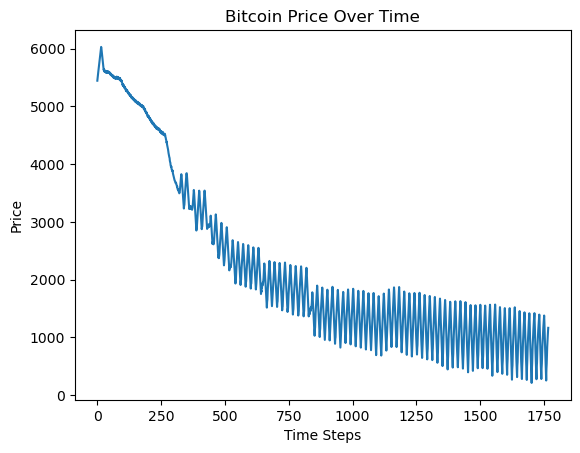

In [1630]:
market.h_price
import matplotlib.pyplot as plt

plt.plot(market.h_price)
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Bitcoin Price Over Time')
plt.show()



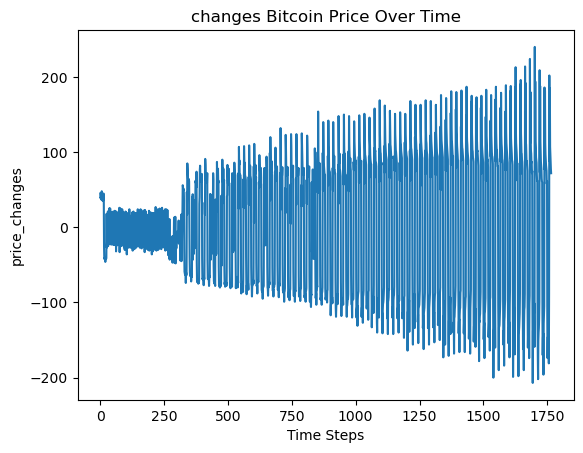

In [1631]:
plt.plot(market.h_price_changes)
plt.xlabel('Time Steps')
plt.ylabel('price_changes')
plt.title('changes Bitcoin Price Over Time')
plt.show()

Differences between kindsof returns: 

Scale of Measurement
* Normal returns represent a percentage change in price.
* Log returns measure the change on a logarithmic scale.

Symmetry
* Log returns are symmetric for gains and losses, while normal returns are not:

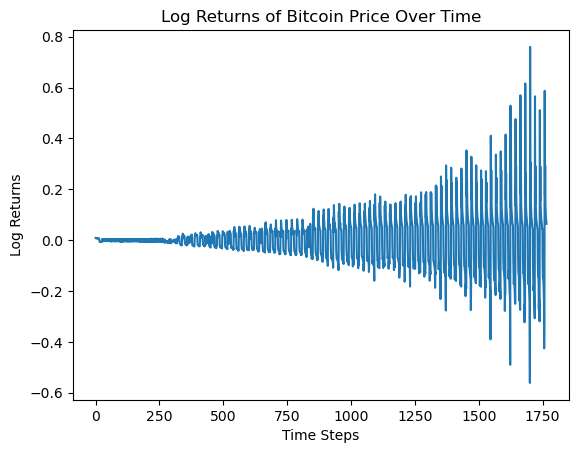

In [1632]:

log_returns = np.log(market.h_price[1:] / np.array(market.h_price[:-1]))
plt.plot(log_returns)
plt.xlabel('Time Steps')
plt.ylabel('Log Returns')
plt.title('Log Returns of Bitcoin Price Over Time')
plt.show()

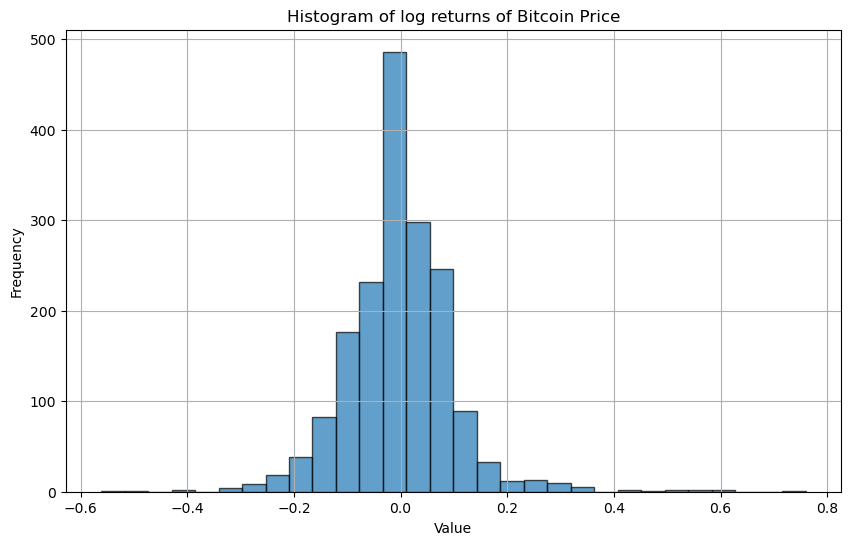

In [1633]:
# Plot the histogram of log returns based on simulated data
plt.figure(figsize=(10, 6))
plt.hist(market.h_log_ret_price, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of log returns of Bitcoin Price')
plt.grid(True)
plt.show()

In [1634]:
from scipy.stats import kurtosis
kurt = kurtosis(market.h_log_ret_price)
kurt

6.605375390888243

### Bitcoin Price - Real world

In [1635]:
# Data
bitcoin_path = os.path.join(os.getcwd(), 'BTC_GBP_Historical Data.csv')
df = pd.read_csv(bitcoin_path, delimiter=',', encoding='utf-8')

#  Preparing the data
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.sort_values(by='Date')
df['Price'] = df['Price'].str.replace(',', '').astype(float) # Remove commas from the 'Price' column and convert it to float

df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1766,2020-01-01,5422.2,"5,444.2","5,496.1","5,412.1",0.16K,-0.40%
1765,2020-01-02,5295.8,"5,422.2","5,442.7","5,272.1",0.35K,-2.33%
1764,2020-01-03,5597.7,"5,295.8","5,660.0","5,229.0",0.52K,5.70%
1763,2020-01-04,5634.2,"5,603.1","5,662.9","5,566.1",0.22K,0.65%
1762,2020-01-05,5630.9,"5,623.1","5,725.0","5,601.0",0.28K,-0.06%


In [1636]:
df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1)).fillna(0)
df

,Date,Price,Open,High,Low,Vol.,Change %,Log_Returns
1766,2020-01-01,5422.2,"5,444.2","5,496.1","5,412.1",0.16K,-0.40%,0.000000
1765,2020-01-02,5295.8,"5,422.2","5,442.7","5,272.1",0.35K,-2.33%,-0.023588
1764,2020-01-03,5597.7,"5,295.8","5,660.0","5,229.0",0.52K,5.70%,0.055442
1763,2020-01-04,5634.2,"5,603.1","5,662.9","5,566.1",0.22K,0.65%,0.006499
1762,2020-01-05,5630.9,"5,623.1","5,725.0","5,601.0",0.28K,-0.06%,-0.000586
...,...,...,...,...,...,...,...,...
4,2024-10-28,53862.1,"52,405.2","54,029.3","52,155.4",0.21K,2.82%,0.027767
3,2024-10-29,54959.7,"53,862.1","56,150.8","53,700.0",0.32K,2.04%,0.020173
2,2024-10-30,55785.8,"54,959.7","56,194.2","54,111.0",0.22K,1.50%,0.014919
1,2024-10-31,54464.6,"55,813.2","56,036.9","53,953.2",0.28K,-2.37%,-0.023968


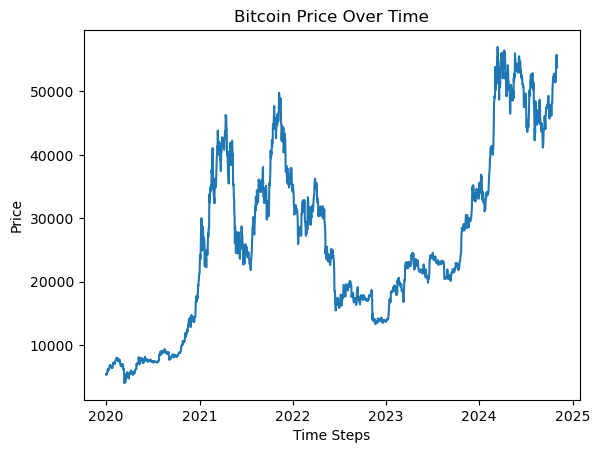

In [1637]:
# Price of bitcoin
market.h_price
import matplotlib.pyplot as plt

plt.plot(df['Date'], df['Price'])
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Bitcoin Price Over Time')
plt.show()

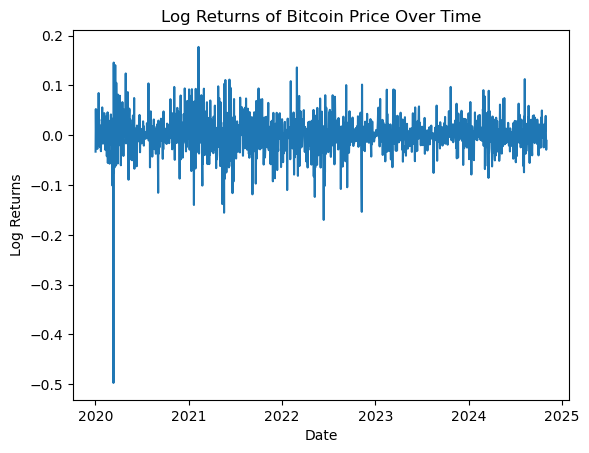

In [ ]:

# Plot the log returns
plt.plot(df['Date'], df['Log_Returns'], color='red')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Log Returns of Real Bitcoin Price Over Time')
plt.show()

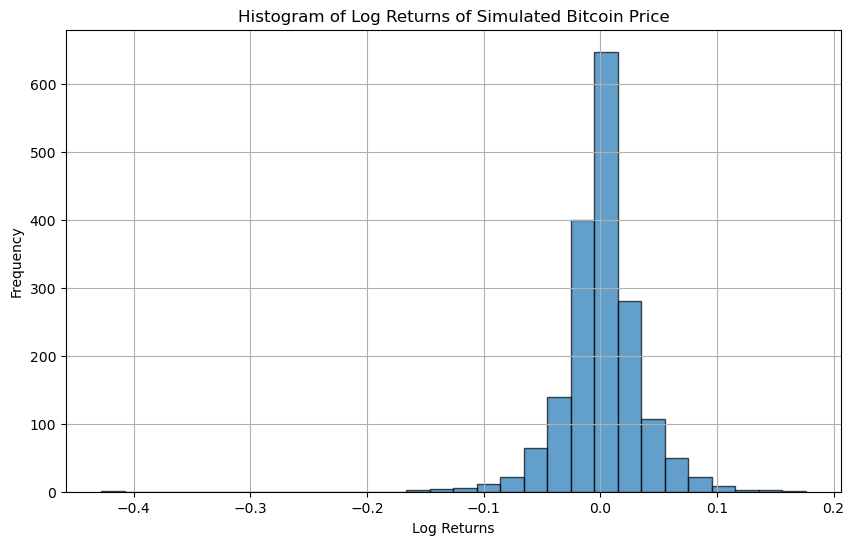

In [1638]:
plt.figure(figsize=(10, 6))
plt.hist(df['Log_Returns'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Log Returns of Simulated Bitcoin Price')
plt.grid(True)
plt.show()


Some statistics

In [1639]:
from scipy.stats import kurtosis
# Main statistics of log returns

# mean
mean = np.mean(df['Log_Returns'])
# skewness
skew = df['Log_Returns'].skew()
# kurtosis
kurt = kurtosis(df['Log_Returns'])

print(f"Mean: {mean}, Skewness: {skew}, Kurtosis: {kurt}")

Mean: 0.0012985130326667626, Skewness: -1.1619569631098754, Kurtosis: 17.302171263622174


### Comparisons between both prices: Simulated and real life prices

In [1640]:
price = pd.DataFrame(market.h_price)
price.describe()

,0
count,1767.000000
mean,2211.694397
std,1491.872510
min,211.000000
25%,1143.000000
50%,1634.000000
75%,2922.500000
max,6029.000000


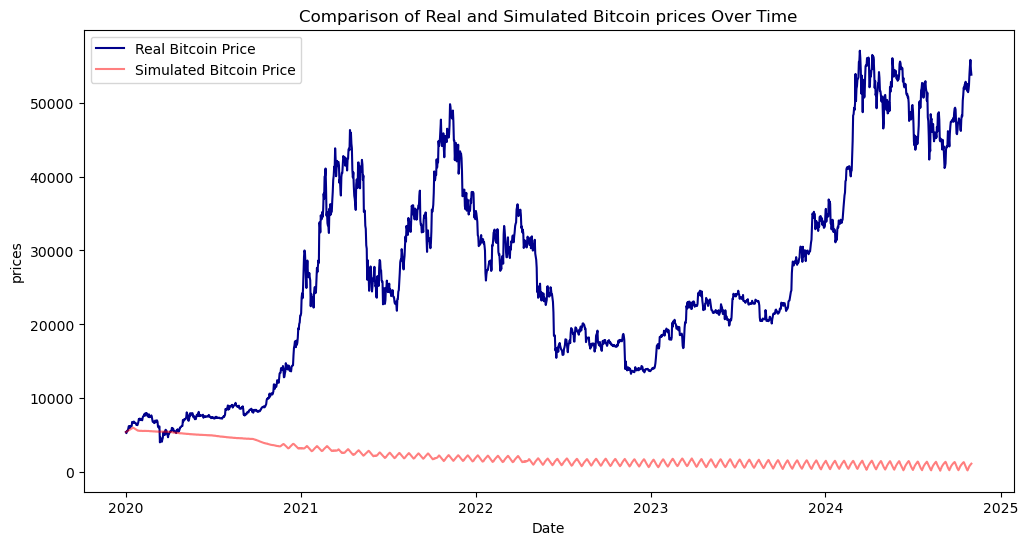

In [1641]:
# Comparing both models: 
prices = df['Price']
prices_s = market.h_price

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], prices, label='Real Bitcoin Price', color='darkblue')
plt.plot(df['Date'][:len(prices)], prices_s, label='Simulated Bitcoin Price', color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('prices')
plt.title('Comparison of Real and Simulated Bitcoin prices Over Time')
plt.legend()
plt.show()

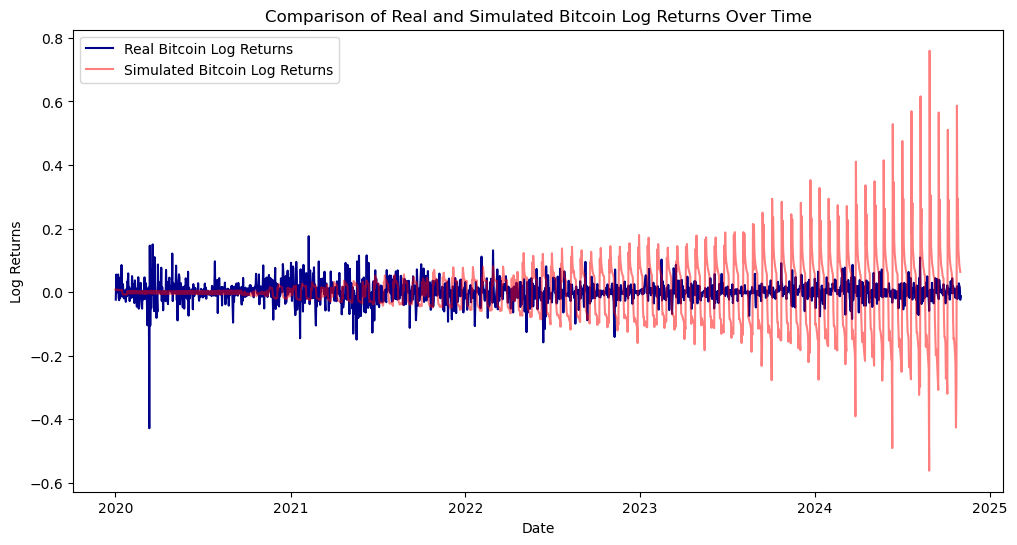

In [1642]:
# Comparing both models: 
log_returns_real = np.log(df['Price'] / df['Price'].shift(1))
log_returns = np.log(market.h_price[1:] / np.array(market.h_price[:-1]))

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], log_returns_real, label='Real Bitcoin Log Returns', color='darkblue')
plt.plot(df['Date'][:len(log_returns)], log_returns, label='Simulated Bitcoin Log Returns', color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Comparison of Real and Simulated Bitcoin Log Returns Over Time')
plt.legend()
plt.show()


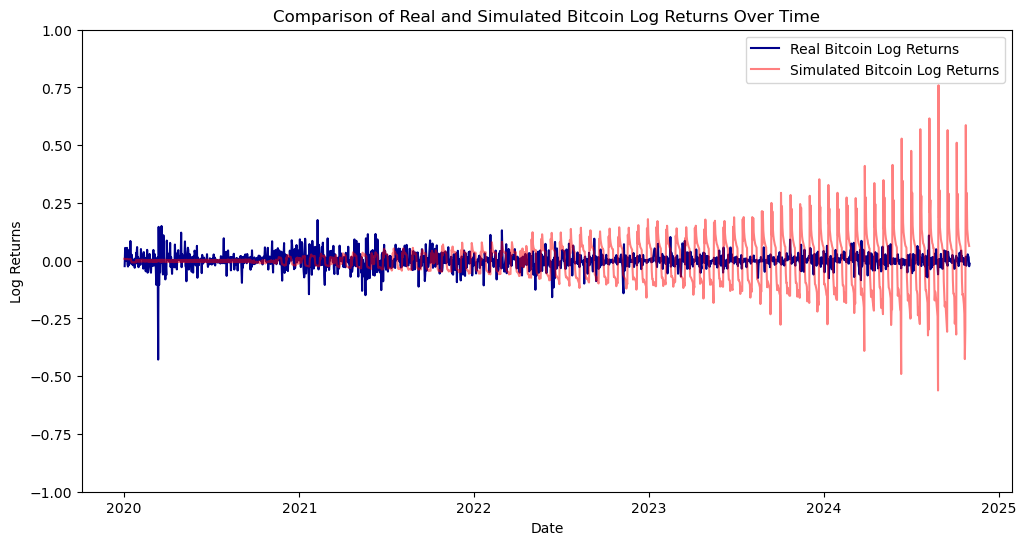

In [1643]:
# Comparing both models: 
log_returns_real = np.log(df['Price'] / df['Price'].shift(1))
log_returns = np.log(market.h_price[1:] / np.array(market.h_price[:-1]))

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], log_returns_real, label='Real Bitcoin Log Returns', color='darkblue')
plt.plot(df['Date'][:len(log_returns)], log_returns, label='Simulated Bitcoin Log Returns', color='red', alpha=0.5)
plt.ylim(-1, 1)
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Comparison of Real and Simulated Bitcoin Log Returns Over Time')
plt.legend()
plt.show()



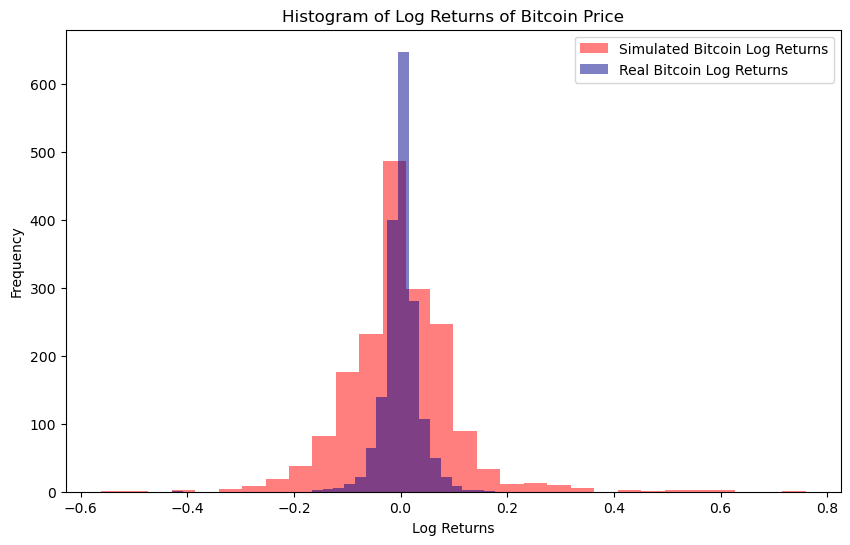

In [1644]:

# comparisons 
plt.figure(figsize=(10, 6))
plt.hist(market.h_log_ret_price, bins=30, alpha=0.5, color='red', label='Simulated Bitcoin Log Returns')#, histtype='stepfilled')
plt.hist(df['Log_Returns'], bins=30, color='darkblue', alpha=0.5, label='Real Bitcoin Log Returns')#, histtype='step')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Log Returns of Bitcoin Price')
plt.legend()
#plt.grid(True)
plt.show()


Stylised facts

In [1645]:
from scipy.stats import kurtosis
# Main statistics of log returns

# mean
mean = np.mean(df['Log_Returns'])
mean_s = np.mean(market.h_log_ret_price)
# skewness
skew = df['Log_Returns'].skew()
skew_s = pd.Series(market.h_log_ret_price).skew()
# kurtosis
kurt = kurtosis(df['Log_Returns'])
kurt_s = kurtosis(market.h_log_ret_price)

print("Stylised facts to ABM validation")
print(f"Real: Mean: {mean}, Skewness: {skew}, Kurtosis: {kurt}")
print(f"Simulated: Mean: {mean_s}, Skewness: {skew_s}, Kurtosis: {kurt_s}")

Stylised facts to ABM validation
Real: Mean: 0.0012985130326667626, Skewness: -1.1619569631098754, Kurtosis: 17.302171263622174
Simulated: Mean: -0.0008730424675943124, Skewness: 0.739336302617463, Kurtosis: 6.605375390888243


In [1646]:
# Calculate the standard deviation of log returns for the simulated data
simulated_volatility = np.std(market.h_log_ret_price)

# Calculate the standard deviation of log returns for the real data
real_volatility = np.std(df['Log_Returns'])

print(f"Simulated Bitcoin Volatility: {simulated_volatility}")
print(f"Real Bitcoin Volatility: {real_volatility}")

Simulated Bitcoin Volatility: 0.10136360939022078
Real Bitcoin Volatility: 0.03365794898584154


Simulated Log Returns Autocorrelation: 0.5324435966516147
Real Log Returns Autocorrelation: -0.07683141232586285


Text(0.5, 1.0, 'Autocorrelation of Log Returns')

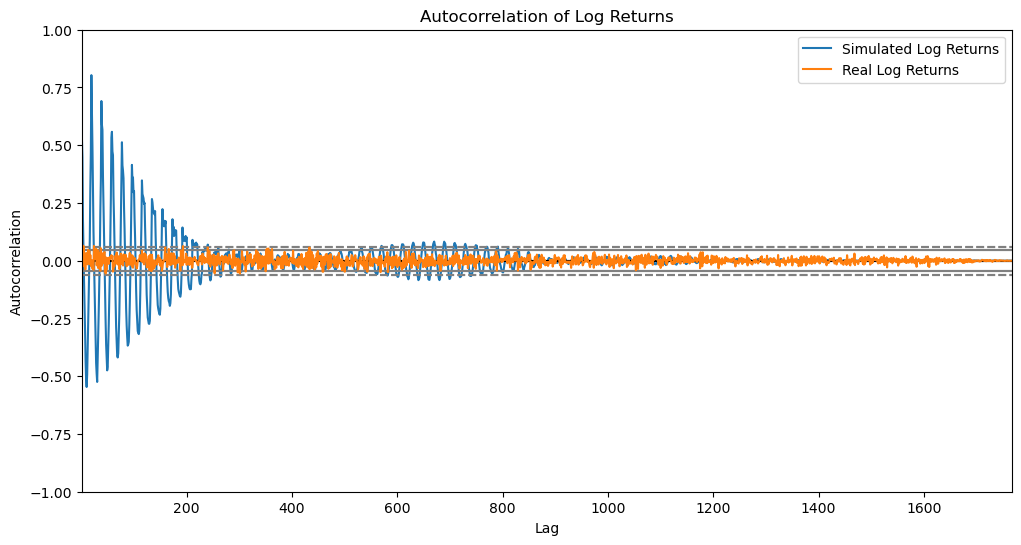

In [1647]:
# Calculate the autocorrelation of log returns for simulated data
simulated_log_returns = pd.Series(market.h_log_ret_price)
simulated_autocorr = simulated_log_returns.autocorr()

# Calculate the autocorrelation of log returns for real data
real_log_returns = df['Log_Returns']
real_autocorr = real_log_returns.autocorr()

print(f"Simulated Log Returns Autocorrelation: {simulated_autocorr}")
print(f"Real Log Returns Autocorrelation: {real_autocorr}")

# Plotting the autocorrelation
plt.figure(figsize=(12, 6))
pd.plotting.autocorrelation_plot(simulated_log_returns, label='Simulated Log Returns')
pd.plotting.autocorrelation_plot(real_log_returns, label='Real Log Returns')
plt.legend()
plt.title('Autocorrelation of Log Returns')

### Decisions momemtum and RSI

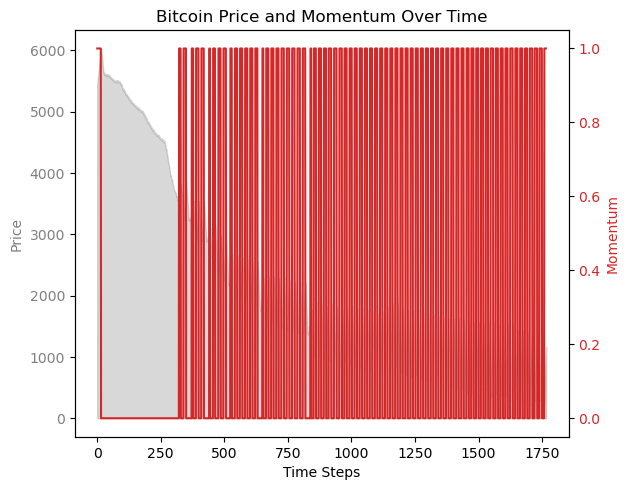

In [1648]:
market.h_momentum
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:gray'
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Price', color=color)
#ax1.plot(market.h_prices, color=color)
ax1.fill_between(range(len(market.h_price)), market.h_price, color=color, alpha=0.3)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Momentum', color=color)
ax2.plot(market.h_momentum, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Bitcoin Price and Momentum Over Time')
plt.show()

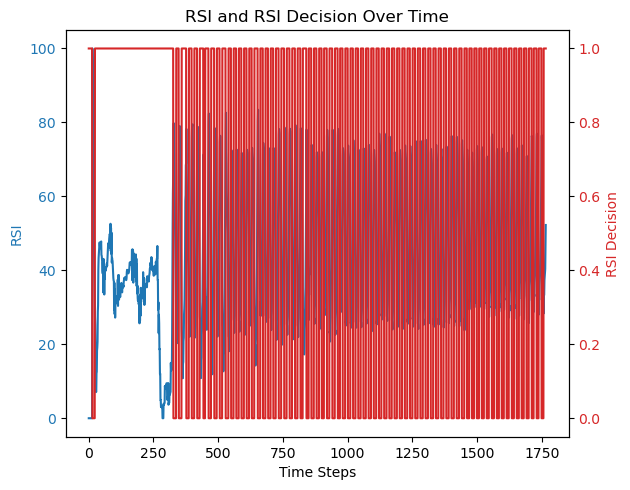

In [1649]:
#market.h_rsi

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('RSI', color=color)
ax1.plot(market.h_rsi, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('RSI Decision', color=color)
ax2.plot(market.h_rsi_decision, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('RSI and RSI Decision Over Time')
plt.show()

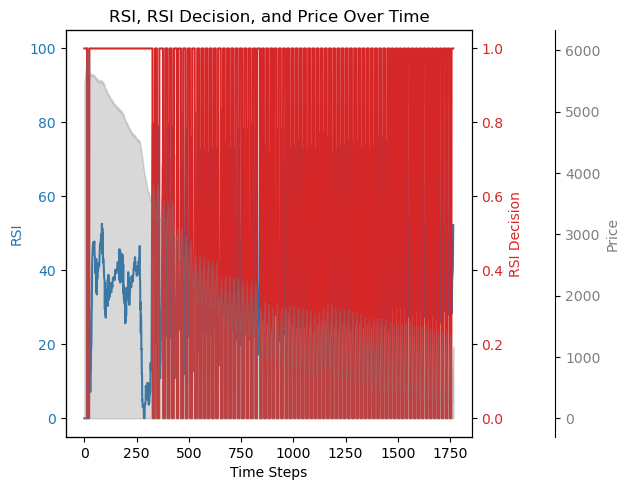

In [1650]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Ploting RSI
color = 'tab:blue'
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('RSI', color=color)
ax1.plot(market.h_rsi, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# second y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('RSI Decision', color=color)
ax2.plot(market.h_rsi_decision, color=color)
ax2.tick_params(axis='y', labelcolor=color)


ax3 = ax1.twinx()  # a third y-axis
ax3.spines['right'].set_position(('outward', 60))  # moving the spine to the right
color = 'tab:gray'
ax3.set_ylabel('Price', color=color)
ax3.fill_between(range(len(market.h_price)), market.h_price, color=color, alpha=0.3)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('RSI, RSI Decision, and Price Over Time')
plt.show()

### Trading volume trends:

In [1651]:
trade_history = pd.DataFrame(market.h_trade_history)
trade_history

,t,buyer,seller,price,volume
0,1,5,1,5444,18.000000
1,1,6,4,5444,18.000000
2,1,7,10,5444,18.000000
3,1,8,18,5444,18.000000
4,1,14,24,5444,18.000000
...,...,...,...,...,...
53001,1766,12,5,1093,110.064064
53002,1766,250,13,1093,110.064064
53003,1766,94,52,1093,110.064064
53004,1766,659,149,1093,110.064064


In [1652]:
trade_history = pd.DataFrame(market.h_trade_history)

# Analysing the volume negociated
volume_by_time = trade_history.groupby('t')['volume'].sum().reset_index(name='total_volume')
volume_by_time
average_volume_by_time = trade_history.groupby('t')['volume'].sum().reset_index(name='average_volume')
average_volume_by_time


,t,average_volume
0,1,684.000000
1,2,342.000000
2,3,414.000000
3,4,360.000000
4,5,270.000000
...,...,...
1757,1762,2201.281281
1758,1763,1210.704705
1759,1764,1320.768769
1760,1765,990.576577


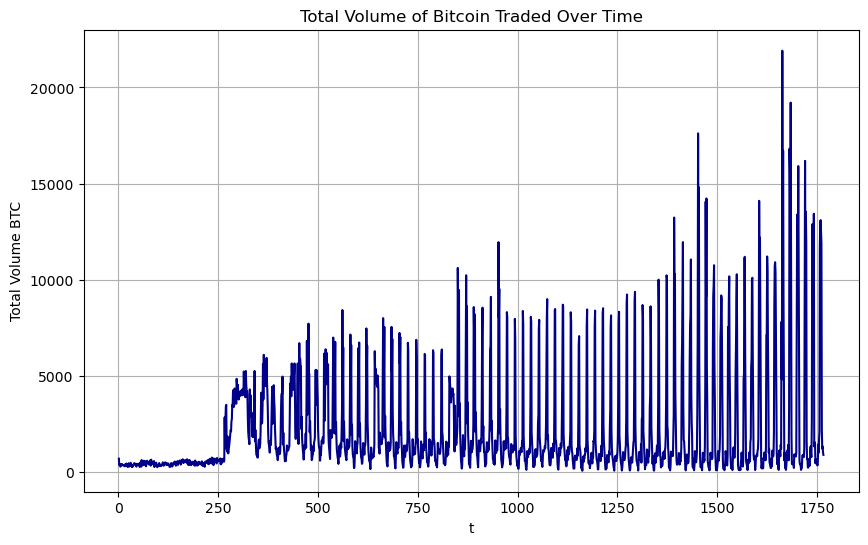

In [1653]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=volume_by_time, x='t', y='total_volume', color='darkblue')
plt.title('Total Volume of Bitcoin Traded Over Time')
plt.xlabel('t')
plt.ylabel('Total Volume BTC')
plt.grid(True)
plt.show()


/var/folders/3m/b2lnmdld3vn81t1nzvv2q3wr0000gn/T/ipykernel_20837/3395642727.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_volume_by_time, x='t', y='average_volume', palette='viridis')


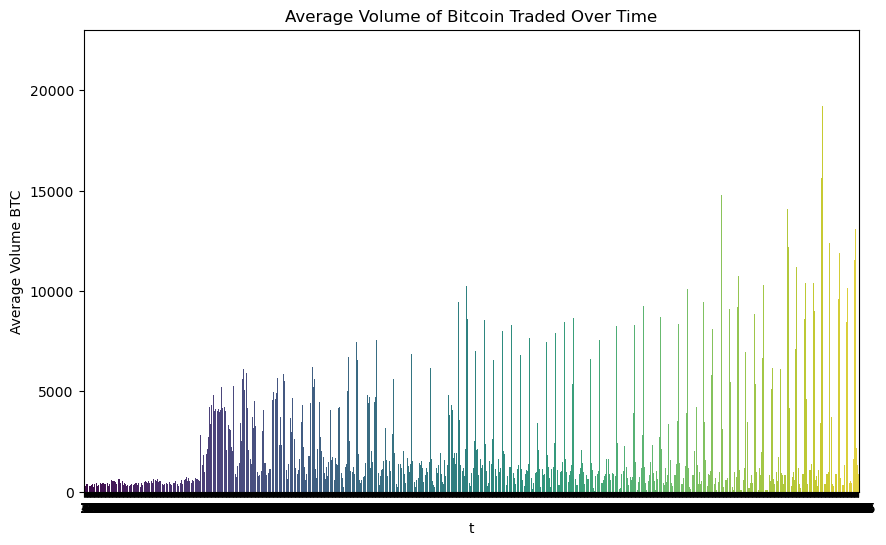

In [1654]:
plt.figure(figsize=(10, 6))
sns.barplot(data=average_volume_by_time, x='t', y='average_volume', palette='viridis')
plt.title('Average Volume of Bitcoin Traded Over Time')
plt.xlabel('t')
plt.ylabel('Average Volume BTC')
plt.show()


In [1655]:
trade_history

,t,buyer,seller,price,volume
0,1,5,1,5444,18.000000
1,1,6,4,5444,18.000000
2,1,7,10,5444,18.000000
3,1,8,18,5444,18.000000
4,1,14,24,5444,18.000000
...,...,...,...,...,...
53001,1766,12,5,1093,110.064064
53002,1766,250,13,1093,110.064064
53003,1766,94,52,1093,110.064064
53004,1766,659,149,1093,110.064064


In [1656]:
# see the trader by agent
buyers = pd.DataFrame(trade_history['buyer'].value_counts())
buyers = buyers.rename(columns={'count': 'buys'}, )
sellers = pd.DataFrame(trade_history['seller'].value_counts())
sellers = sellers.rename(columns={'count': 'sells'})


agents_trader = pd.concat([buyers, sellers], axis=1).fillna(0)
agents_trader['total'] = agents_trader['buys'] + agents_trader['sells']
agents_trader
agents_trader['total'] = agents_trader['buys'] + agents_trader['sells']
agents_trader.reset_index(inplace=True)
agents_trader.rename(columns={'index': 'agent_id'}, inplace=True)
agents_trader

agent_id_type = agent_history[['Agent_ID', 'Type']].drop_duplicates()
agent_id_type

# Merging the dataframes
agents_trader = pd.merge(agents_trader, agent_id_type, left_on='agent_id', right_on='Agent_ID', how='left')
agents_trader.groupby('Type')['total'].describe()


,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
C1,150.0,121.206667,38.048238,27.0,98.25,122.5,154.00,181.0
C2,150.0,73.780000,15.105832,39.0,63.25,75.0,83.00,117.0
C3,150.0,70.520000,21.170677,16.0,62.00,73.5,82.75,112.0
C4,150.0,3.500000,3.203920,1.0,1.00,1.0,6.00,14.0
CT,99.0,85.585859,17.405142,49.0,74.00,86.0,94.00,141.0
R,300.0,190.626667,60.671719,76.0,145.75,182.5,225.25,385.0


In [1657]:
agents_trader

,agent_id,buys,sells,total,Agent_ID,Type
0,10,192,193.0,385.0,10,R
1,7,178,178.0,356.0,7,R
2,75,175,176.0,351.0,75,R
3,135,172,173.0,345.0,135,R
4,73,172,173.0,345.0,73,R
...,...,...,...,...,...,...
994,813,1,0.0,1.0,813,C4
995,807,1,0.0,1.0,807,C4
996,804,1,0.0,1.0,804,C4
997,801,1,0.0,1.0,801,C4


/var/folders/3m/b2lnmdld3vn81t1nzvv2q3wr0000gn/T/ipykernel_20837/2746450990.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agents_trader, x='Type', y='total', palette='viridis')


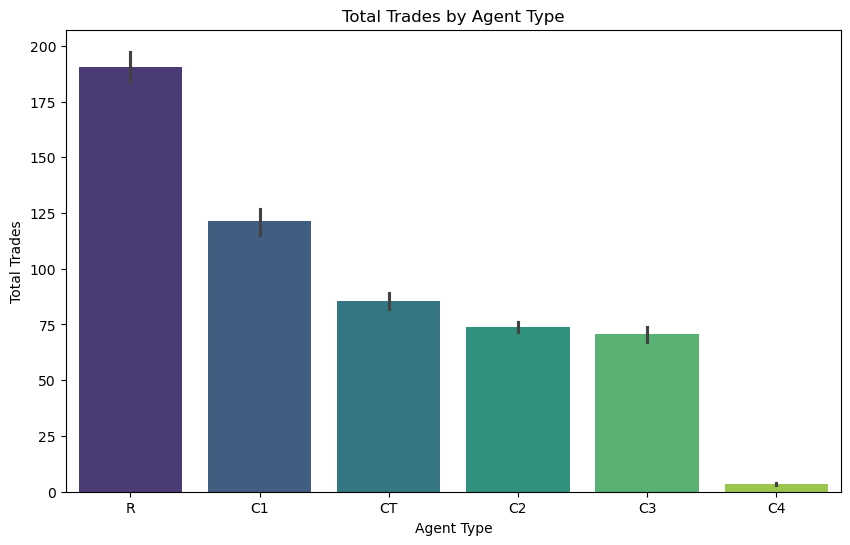

In [1658]:
# ploting the real trades by each type of agent
plt.figure(figsize=(10, 6))
sns.barplot(data=agents_trader, x='Type', y='total', palette='viridis')
plt.title('Total Trades by Agent Type')
plt.xlabel('Agent Type')
plt.ylabel('Total Trades')
plt.show()


<Figure size 1000x600 with 0 Axes>

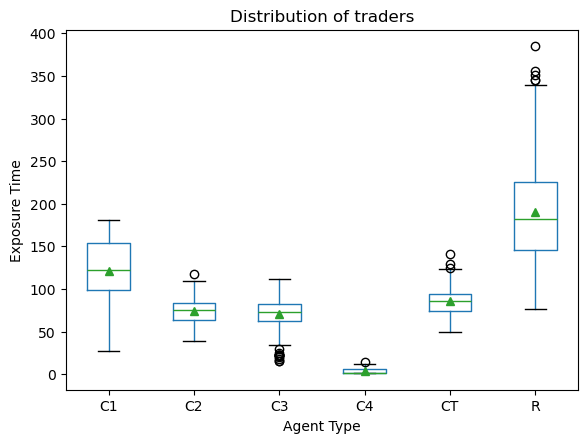

In [1659]:
plt.figure(figsize=(10, 6))
boxplot = agents_trader.boxplot(column='total', by='Type', grid=False, showmeans=True)

plt.xlabel('Agent Type')
plt.ylabel('Exposure Time')
plt.title('Distribution of traders')
plt.suptitle('')  
plt.show()

In [1660]:
# see the trader by agent
buyers = pd.DataFrame(trade_history['buyer'].value_counts())
buyers = buyers.rename(columns={'count': 'buys'}, )
sellers = pd.DataFrame(trade_history['seller'].value_counts())
sellers = sellers.rename(columns={'count': 'sells'})


agents_trader = pd.concat([buyers, sellers], axis=1).fillna(0)
agents_trader['total'] = agents_trader['buys'] + agents_trader['sells']
agents_trader
agents_trader['total'] = agents_trader['buys'] + agents_trader['sells']
agents_trader.reset_index(inplace=True)
agents_trader.rename(columns={'index': 'agent_id'}, inplace=True)
agents_trader

agent_id_type = agent_history[['Agent_ID', 'Type']].drop_duplicates()
agent_id_type

# Merging the dataframes
agents_trader = pd.merge(agents_trader, agent_id_type, left_on='agent_id', right_on='Agent_ID', how='left')
agents_trader.groupby('Type')['total'].describe()


,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
C1,150.0,121.206667,38.048238,27.0,98.25,122.5,154.00,181.0
C2,150.0,73.780000,15.105832,39.0,63.25,75.0,83.00,117.0
C3,150.0,70.520000,21.170677,16.0,62.00,73.5,82.75,112.0
C4,150.0,3.500000,3.203920,1.0,1.00,1.0,6.00,14.0
CT,99.0,85.585859,17.405142,49.0,74.00,86.0,94.00,141.0
R,300.0,190.626667,60.671719,76.0,145.75,182.5,225.25,385.0


## Performance Comparison

### Ratio of GBP to Bitcoin Held:

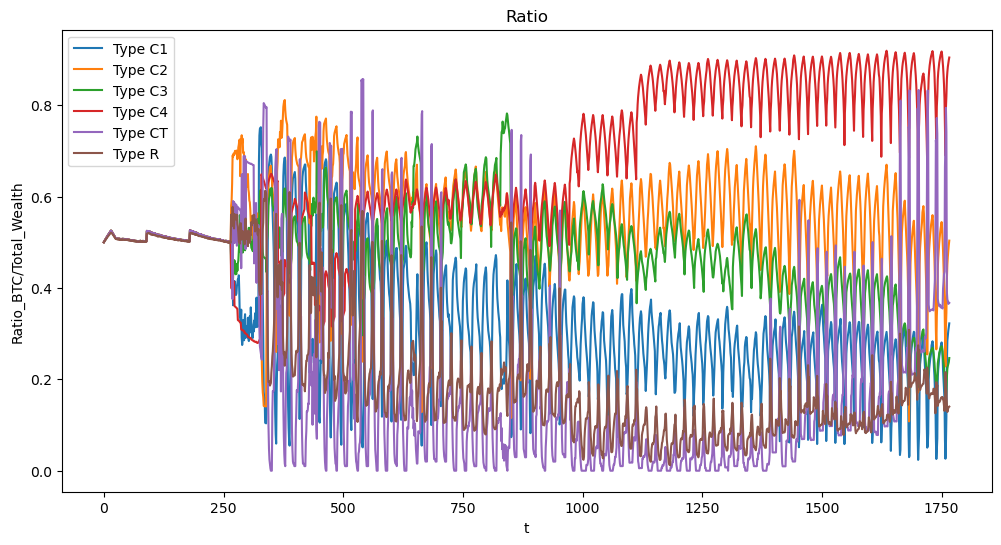

In [1661]:
ratio_evolution = agent_history.groupby(['Type', 'Time'])['Ratio_BTC'].agg(['mean','median', 'std']).reset_index()

plt.figure(figsize=(12, 6))
for agent_type in ratio_evolution['Type'].unique():
    data = ratio_evolution[ratio_evolution['Type'] == agent_type]
    plt.plot(data['Time'], data['mean'], label=f"Type {agent_type}")
    #plt.fill_between(data['Time'], data['mean'] - data['std'], data['mean'] + data['std'], alpha=0.3)
    

plt.title("Ratio")
plt.xlabel("t")
plt.ylabel("Ratio_BTC/Total_Wealth")
plt.legend()
plt.show()

In [1662]:
ratio_evolution = agent_history.groupby(['Type', 'Time'])['Ratio_BTC'].agg(['mean', 'std']).reset_index()
#ratio_evolution['mean'] = ratio_evolution['mean'] * 100 # percentage
#ratio_evolution['std'] = ratio_evolution['std'] * 100 # percentage
ratio_evolution[ratio_evolution['Time'] == t]

,Type,Time,mean,std
1766,C1,1766,0.322421,0.325422
3533,C2,1766,0.503520,0.311817
5300,C3,1766,0.246585,0.367060
7067,C4,1766,0.904194,0.051988
8834,CT,1766,0.367300,0.468027
10601,R,1766,0.140295,0.322336


### Total Wealth (GBP + Bitcoin):

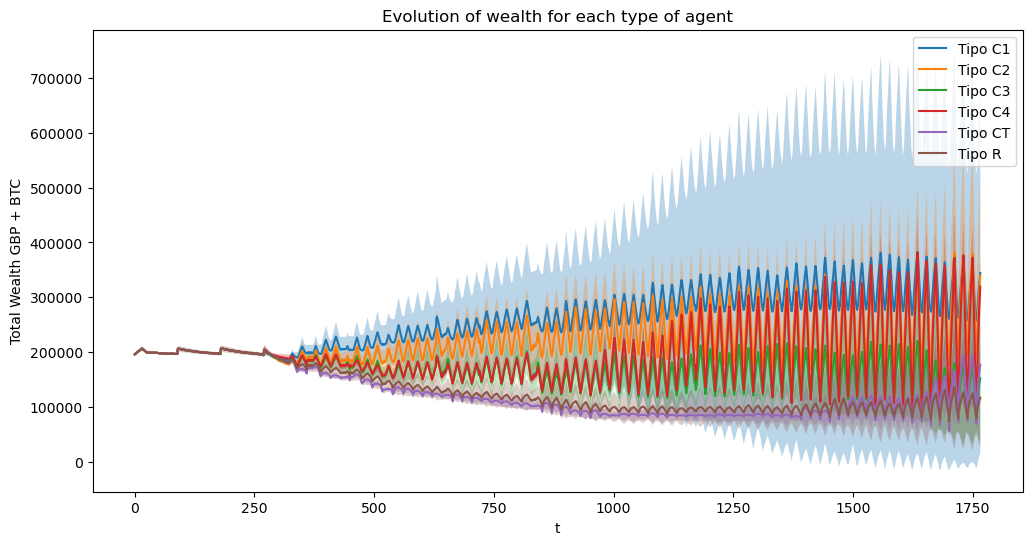

In [1663]:
wealth_evolution = agent_history.groupby(['Type', 'Time'])['Total_Wealth'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(12, 6))
for agent_type in wealth_evolution['Type'].unique():
    data = wealth_evolution[wealth_evolution['Type'] == agent_type]
    plt.plot(data['Time'], data['mean'], label=f"Tipo {agent_type}")
    plt.fill_between(data['Time'], data['mean'] - data['std'], data['mean'] + data['std'], alpha=0.3)

plt.title("Evolution of wealth for each type of agent")
plt.xlabel("t")
plt.ylabel("Total Wealth GBP + BTC")
plt.legend()
plt.show()

Evolution of wealth of a particular agent:

In [1664]:
agent_history[agent_history['Type'] == 'CT']

,Time,Date,Agent_ID,Type,Position,Decision,Total_Wealth,GBP,BTC,BTC_in_GBP,Ratio_GBP,Ratio_BTC
900,0,2020-01-01,901,CT,False,initial,195984.000000,97992.000000,18.000000,97992.000000,0.500000,0.500000
901,0,2020-01-01,902,CT,True,initial,195984.000000,97992.000000,18.000000,97992.000000,0.500000,0.500000
902,0,2020-01-01,903,CT,True,initial,195984.000000,97992.000000,18.000000,97992.000000,0.500000,0.500000
903,0,2020-01-01,904,CT,True,initial,195984.000000,97992.000000,18.000000,97992.000000,0.500000,0.500000
904,0,2020-01-01,905,CT,True,initial,195984.000000,97992.000000,18.000000,97992.000000,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
1765228,1766,2024-11-01,995,CT,False,hold,102207.062062,102207.062062,0.000000,0.000000,1.000000,0.000000
1765229,1766,2024-11-01,996,CT,False,hold,126419.713714,126419.713714,0.000000,0.000000,1.000000,0.000000
1765230,1766,2024-11-01,997,CT,False,hold,131311.232232,131311.232232,0.000000,0.000000,1.000000,0.000000
1765231,1766,2024-11-01,998,CT,True,sell,261608.724725,5159.455455,220.128128,256449.269269,0.019722,0.980278


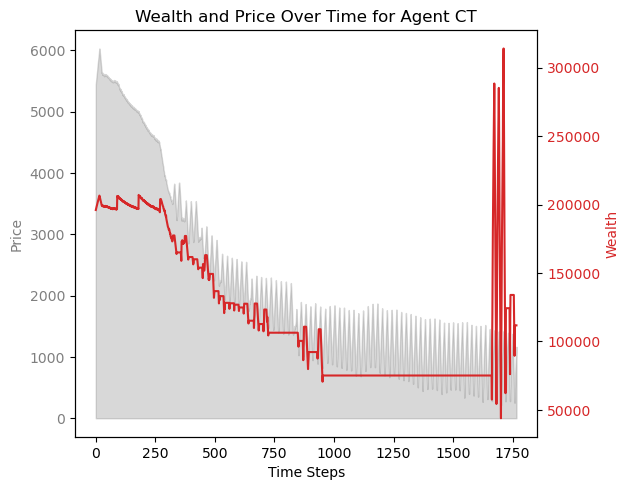

In [1665]:
id_agent = 998
fig, ax1 = plt.subplots()

color = 'tab:gray'
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Price', color=color)
#ax1.plot(market.h_prices, color=color)
ax1.fill_between(range(len(market.h_price)), market.h_price, color=color, alpha=0.3)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Wealth', color=color)
ax2.plot(market.agents[id_agent].h_wealth, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()
plt.title(f'Wealth and Price Over Time for Agent {market.agents[id_agent].type}')
plt.show()

### Exposure Time: 

Measure the percentage of time the agents have an open position in the market over the simulation period.

In [1666]:
agent_exposure = agent_history.groupby(['Type', 'Agent_ID'])['Position'].mean().reset_index()
agent_exposure

,Type,Agent_ID,Position
0,C1,301,0.601585
1,C1,302,0.771930
2,C1,303,0.611771
3,C1,304,0.773628
4,C1,305,0.251839
...,...,...,...
994,R,296,0.315789
995,R,297,0.149406
996,R,298,0.436899
997,R,299,0.151104


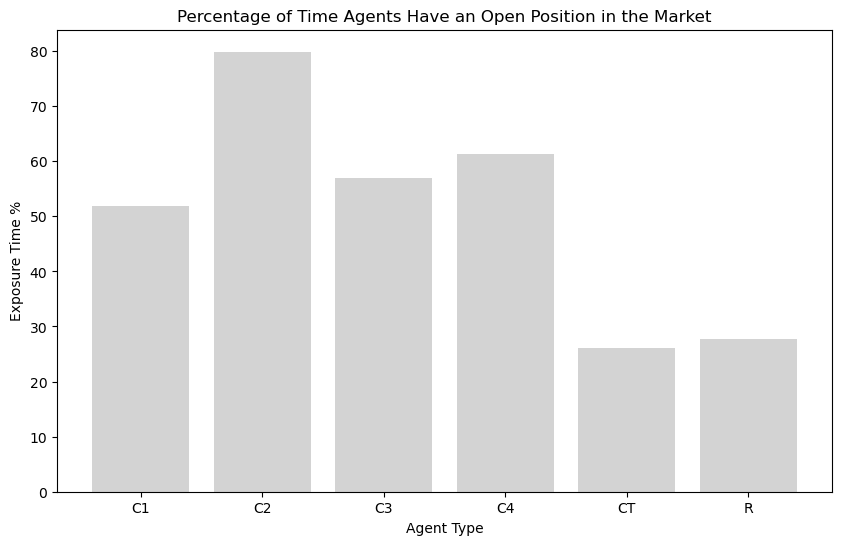

In [1667]:
agent_exposure = agent_history.groupby(['Type', 'Agent_ID'])['Position'].mean().reset_index()

type_exposure = agent_exposure.groupby('Type')['Position'].mean().reset_index()
type_exposure.rename(columns={'Position': 'Exposure'}, inplace=True)

type_exposure['Exposure'] = type_exposure['Exposure'] * 100 # percentage

plt.figure(figsize=(10, 6))
plt.bar(type_exposure['Type'], type_exposure['Exposure'], color='lightgray')
plt.xlabel('Agent Type')
plt.ylabel('Exposure Time %')
plt.title('Percentage of Time Agents Have an Open Position in the Market')
#plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

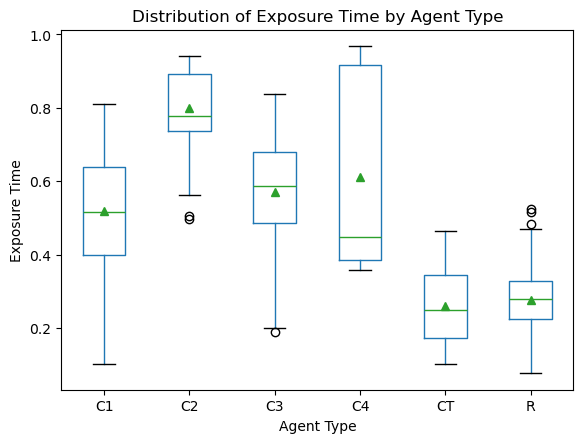

In [1668]:
plt.figure(figsize=(10, 6))
boxplot = agent_exposure.boxplot(column='Position', by='Type', grid=False, showmeans=True)

plt.xlabel('Agent Type')
plt.ylabel('Exposure Time')
plt.title('Distribution of Exposure Time by Agent Type')
plt.suptitle('')  
plt.show()

Regarding decisions: 

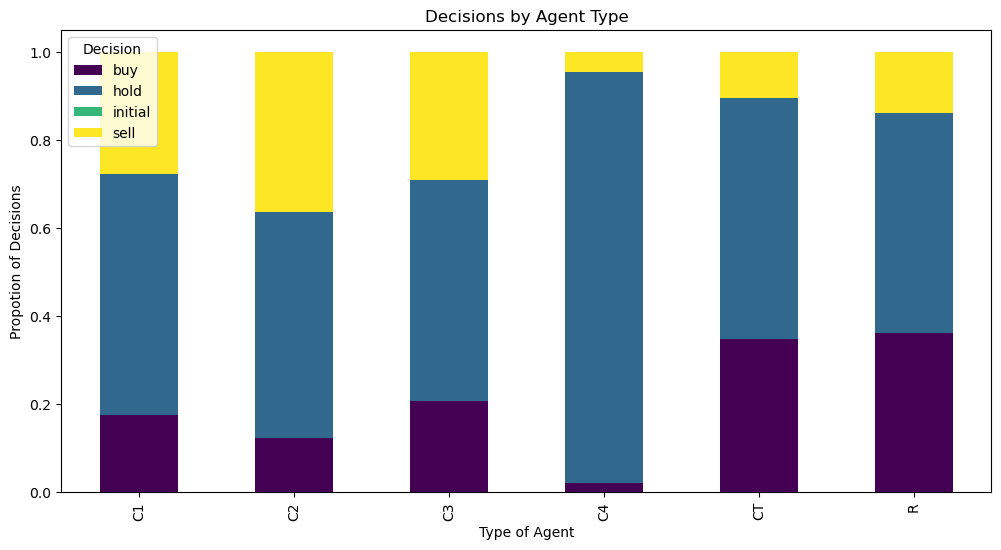

In [1669]:
decisions = (
    agent_history.groupby(['Type', 'Decision'])['Decision'].count().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)
)

decisions.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis') #tab10 # RdYlGn #viridis # Dark2
plt.title("Decisions by Agent Type")
plt.xlabel("Type of Agent")
plt.ylabel("Propotion of Decisions")
plt.legend(title="Decision")
plt.show()

### Win Rate: 

Calculate the percentage of profitable trades for each agent type to understand their trading effectiveness and consistency in generating positive returns

In [1670]:
# To calculate win rate, the differences in the wealth over time is calculated.

agent_history['Wealth_Change'] = agent_history.groupby('Agent_ID')['Total_Wealth'].diff()
agent_history['Profitable_Trade'] = agent_history['Wealth_Change'] > 0

win_rate = agent_history.groupby(['Type', 'Agent_ID'])['Profitable_Trade'].mean().reset_index() #grouping the win rate of each agent
win_rate


,Type,Agent_ID,Profitable_Trade
0,C1,301,0.422750
1,C1,302,0.420487
2,C1,303,0.413130
3,C1,304,0.419355
4,C1,305,0.382569
...,...,...,...
994,R,296,0.139785
995,R,297,0.128466
996,R,298,0.195812
997,R,299,0.132428


In [1671]:
win_rate.groupby('Type')['Profitable_Trade'].describe()


,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
C1,150.0,0.322569,0.075805,0.151669,0.267827,0.322581,0.391483,0.434635
C2,150.0,0.444011,0.035458,0.235993,0.436899,0.452462,0.466469,0.481041
C3,150.0,0.331851,0.056227,0.184493,0.293577,0.340125,0.369836,0.452179
C4,150.0,0.479736,0.015901,0.445954,0.464771,0.492360,0.492360,0.492360
CT,99.0,0.149972,0.017622,0.117148,0.136672,0.148840,0.160158,0.200340
R,300.0,0.146040,0.032494,0.080928,0.122524,0.143181,0.169213,0.247878


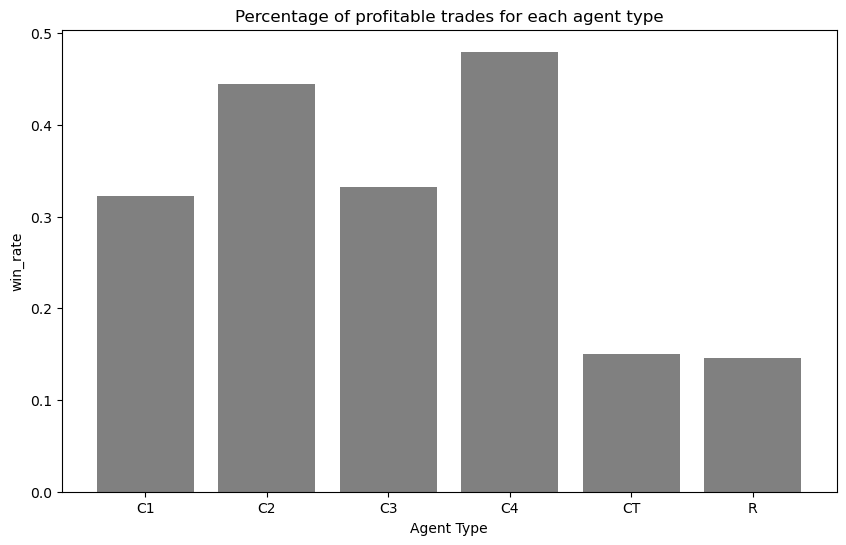

In [1672]:
win_rate = agent_history.groupby(['Type', 'Agent_ID'])['Profitable_Trade'].mean().reset_index()

type_winrate = win_rate.groupby('Type')['Profitable_Trade'].mean().reset_index()
type_winrate.rename(columns={'Profitable_Trade': 'win_rate'}, inplace=True)

#type_exposure['Exposure'] = type_exposure['Exposure'] * 100 # percentage

plt.figure(figsize=(10, 6))
plt.bar(type_winrate['Type'], type_winrate['win_rate'], color='gray')
plt.xlabel('Agent Type')
plt.ylabel('win_rate')
plt.title('Percentage of profitable trades for each agent type')
#plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

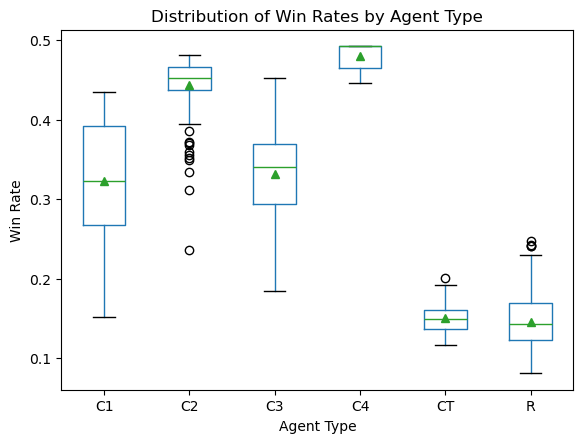

In [1673]:
plt.figure(figsize=(10, 6))

win_rate.boxplot(column='Profitable_Trade', by='Type', grid=False, showmeans=True)
#plt.ylim(0, 0.6)
plt.xlabel('Agent Type')
plt.ylabel('Win Rate')
plt.title('Distribution of Win Rates by Agent Type')
plt.suptitle('')  # Remove the automatic 'Boxplot grouped by Type' title
plt.show()

### Maximum Drawdown:

Measure the maximum drawdown (the largest peak-to- trough decline) experienced by each agent type.

In [1674]:
# Adding new variables to the agent history
agent_history['Cumulative_Max'] = agent_history.groupby('Agent_ID')['Total_Wealth'].cummax()
agent_history['Drawdown'] = (agent_history['Total_Wealth'] - agent_history['Cumulative_Max']) / agent_history['Cumulative_Max']
agent_history[agent_history['Agent_ID'] == 1].head(5)

,Time,Date,Agent_ID,Type,Position,Decision,Total_Wealth,GBP,BTC,BTC_in_GBP,Ratio_GBP,Ratio_BTC,Wealth_Change,Profitable_Trade,Cumulative_Max,Drawdown
0,0,2020-01-01,1,R,True,initial,195984.0,97992.0,18.0,97992.0,0.5,0.5,NaN,False,195984.0,0.0
999,1,2020-01-02,1,R,False,sell,195984.0,195984.0,0.0,0.0,1.0,0.0,0.0,False,195984.0,0.0
1998,2,2020-01-03,1,R,False,hold,195984.0,195984.0,0.0,0.0,1.0,0.0,0.0,False,195984.0,0.0
2997,3,2020-01-04,1,R,False,hold,195984.0,195984.0,0.0,0.0,1.0,0.0,0.0,False,195984.0,0.0
3996,4,2020-01-05,1,R,False,hold,195984.0,195984.0,0.0,0.0,1.0,0.0,0.0,False,195984.0,0.0


In [1675]:
# Statistics of the drawdown
drawdown_stats = agent_history.groupby(['Type', 'Agent_ID'])['Drawdown'].describe()
drawdown_stats.to_excel('drawdown_statistics.xlsx', index=True)
agent_history.groupby(['Type'])['Drawdown'].describe()

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
C1,265050.0,-0.248202,0.229946,-0.875304,-0.423999,-0.157695,-0.050504,0.0
C2,265050.0,-0.207419,0.181171,-0.884394,-0.297534,-0.160066,-0.056183,0.0
C3,265050.0,-0.300183,0.227719,-0.936037,-0.478512,-0.254099,-0.099395,0.0
C4,265050.0,-0.215997,0.168977,-0.842578,-0.303625,-0.180753,-0.082176,0.0
CT,174933.0,-0.408503,0.219789,-0.874890,-0.595874,-0.479863,-0.241871,0.0
R,530100.0,-0.405440,0.233390,-0.913799,-0.605844,-0.460872,-0.197575,0.0


<Figure size 1000x600 with 0 Axes>

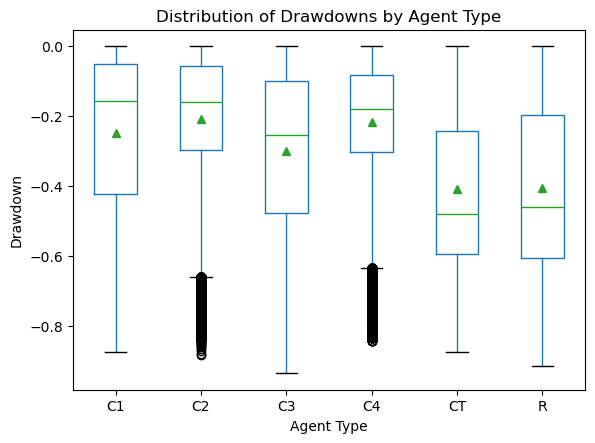

In [1676]:

plt.figure(figsize=(10, 6))
boxplot = agent_history.boxplot(column='Drawdown', by='Type', grid=False, showmeans=True)

plt.xlabel('Agent Type')
plt.ylabel('Drawdown')
plt.title('Distribution of Drawdowns by Agent Type')
plt.suptitle('') 

plt.show()

# Metrics to review the model

In [1677]:
agent_hist_grouped = agent_history.groupby('Time').sum('BTC')
agent_hist_grouped[89:106]


,Agent_ID,Position,Total_Wealth,GBP,BTC,BTC_in_GBP,Ratio_GBP,Ratio_BTC,Wealth_Change,Profitable_Trade,Cumulative_Max,Drawdown
Time,,,,,,,,,,,,
89,499500,484,196615188.0,97894008.0,17982.0,98721180.0,497.592596,501.407404,377622.0,961,2.063075e+08,-46.829802
90,499500,484,206011488.0,97894008.0,19780.0,108117480.0,476.591826,522.408174,9396300.0,961,2.067518e+08,-3.527592
91,499500,484,205536768.0,97894008.0,19780.0,107642760.0,477.208637,521.791363,-474720.0,0,2.067518e+08,-5.817462
92,499500,484,205853248.0,97894008.0,19780.0,107959240.0,476.402300,522.597700,316480.0,961,2.067548e+08,-4.305462
93,499500,484,205418088.0,97894008.0,19780.0,107524080.0,477.235920,521.764080,-435160.0,0,2.067548e+08,-6.404212
94,499500,484,205754348.0,97894008.0,19780.0,107860340.0,476.530660,522.469340,336260.0,961,2.067573e+08,-4.794062
95,499500,484,205220288.0,97894008.0,19780.0,107326280.0,477.657592,521.342408,-534060.0,0,2.067573e+08,-7.369918
96,499500,484,205457648.0,97894008.0,19780.0,107563640.0,477.202192,521.797808,237360.0,961,2.067579e+08,-6.228368
97,499500,484,204864248.0,97894008.0,19780.0,106970240.0,478.562977,520.437023,-593400.0,0,2.067579e+08,-9.090226


In [1678]:
agent_hist_grouped.to_excel('agent_hist_grouped.xlsx', index=True)

In [1679]:
market.h_orders
# Convert orders to a DataFrame
orders_df = pd.DataFrame(market.h_orders)
orders_df[orders_df['t'] == 1].sort_values(by='type').head(5)

,t,agent_id,type,q_btc
189,1,377,buy,18.0
258,1,505,buy,18.0
257,1,504,buy,18.0
256,1,503,buy,18.0
255,1,501,buy,18.0


In [1680]:
import pandas as pd

market.h_trade_history
# Convert trade history to a DataFrame
trade_history_df = pd.DataFrame(market.h_trade_history)
trade_history_df[trade_history_df['t'] == 5]

,t,buyer,seller,price,volume
100,5,23,2,5606,18.0
101,5,101,9,5606,18.0
102,5,224,12,5606,18.0
103,5,161,26,5606,18.0
104,5,46,34,5606,18.0
105,5,87,53,5606,18.0
106,5,200,62,5606,18.0
107,5,66,75,5606,18.0
108,5,59,96,5606,18.0
109,5,41,103,5606,18.0


# New Agent Design 

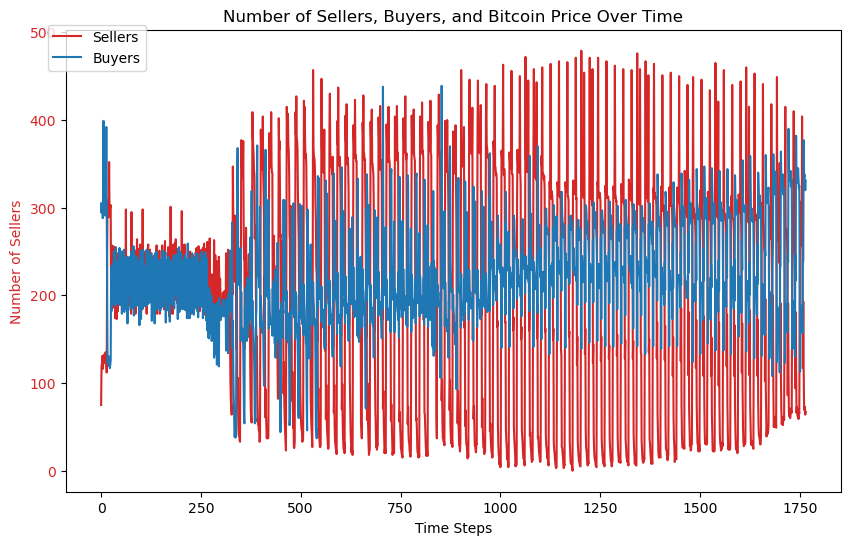

In [1681]:

fig, ax1 = plt.subplots(figsize=(10, 6))

color_sell = 'tab:red'
color_buy = 'tab:blue'
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Number of Sellers', color=color)
ax1.plot(market.h_sellers, label='Sellers', color=color_sell)
ax1.plot(market.h_buyers, label='Buyers', color=color_buy)
ax1.tick_params(axis='y', labelcolor=color)


# ax2 = ax1.twinx()
# ax2.spines['right'].set_position(('outward', 60))
# color = 'tab:gray'
# ax2.set_ylabel('Price', color=color)
# #ax2.plot(market.h_price, color=color, alpha=0.3)
# #ax2.fill_between(range(len(market.h_price)), market.h_price, color=color, alpha=0.2)
# ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()
plt.title('Number of Sellers, Buyers, and Bitcoin Price Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()